In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 10 17:00:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install difflogic

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [3]:
from difflogic import LogicLayer, GroupSum, CompiledLogicNet
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda"

In [4]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [5]:
def test(model, inputs, outputs, loss_fn):
    model.eval()
    pred = torch.zeros(outputs.size(0), dtype=torch.float)
    with torch.no_grad():
        for i, x in tqdm(enumerate(inputs)):
            y = model(torch.Tensor([x]))
            pred[i] = y
    loss = loss_fn(pred, outputs.float())
    print(f"Loss: {loss.item()}")
    return pred

In [6]:
inputs = torch.arange(0, 2**8, dtype=float, device=device)
outputs = inputs
dataset = torch.utils.data.TensorDataset(inputs, outputs)
dataloader = DataLoader(dataset, batch_size=64)

In [ ]:
class EightBitNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            LogicLayer(8, 2048),
            LogicLayer(2048, 1024),
            LogicLayer(1024, 512),
            LogicLayer(512, 256),
            LogicLayer(256, 128),
            LogicLayer(128, 64),
            LogicLayer(64, 32),
            LogicLayer(32, 16),
            LogicLayer(16, 8),
        )

    def forward(self, X):
        X = X.to(int)
        # convert int to bits
        X = [[(x & (1 << i)) >> i for i in range(8)] for x in X]
        # TODO: do batches properly
        X = torch.tensor(X, dtype=float, device=device)
        Y = self.model(X)
        # convert bits to int
        place_values = 2**torch.arange(0, 8, dtype=float, device=device)
        return torch.sum(place_values * Y, -1)

In [ ]:
model = EightBitNet().to('cuda')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
i = 0
for _ in range(100):
    train(dataloader, model, loss_fn, optimizer)

loss: 8405.856265  [   64/  256]
loss: 8697.603213  [   64/  256]
loss: 8962.315203  [   64/  256]
loss: 9184.616847  [   64/  256]
loss: 9360.314224  [   64/  256]
loss: 9491.244759  [   64/  256]
loss: 9582.390813  [   64/  256]
loss: 9640.103001  [   64/  256]
loss: 9670.393314  [   64/  256]
loss: 9675.232722  [   64/  256]
loss: 9637.469598  [   64/  256]
loss: 9467.071115  [   64/  256]
loss: 8788.603700  [   64/  256]
loss: 6774.868520  [   64/  256]
loss: 3648.640033  [   64/  256]
loss: 1481.730109  [   64/  256]
loss: 759.889721  [   64/  256]
loss: 636.876777  [   64/  256]
loss: 732.683168  [   64/  256]
loss: 965.490395  [   64/  256]
loss: 1249.938790  [   64/  256]
loss: 1462.288057  [   64/  256]
loss: 1540.378045  [   64/  256]
loss: 1450.107519  [   64/  256]
loss: 1178.841093  [   64/  256]
loss: 804.918686  [   64/  256]
loss: 503.855318  [   64/  256]
loss: 371.966040  [   64/  256]
loss: 329.842098  [   64/  256]
loss: 300.683120  [   64/  256]
loss: 251.315675  [

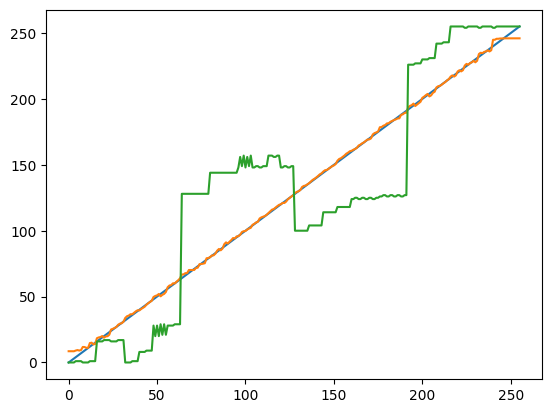

In [ ]:
model.train()
train_output = model(inputs).detach()
model.eval()
test_output = model(inputs).detach()

plt.plot(outputs.cpu())
plt.plot(train_output.cpu())
plt.plot(test_output.cpu())

In [28]:
class GroupSumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            LogicLayer(255, 2048),
            LogicLayer(2048, 1024),
            LogicLayer(1024, 512),
            LogicLayer(512, 256),
            LogicLayer(256, 255),
            GroupSum(1),
        )

    def forward(self, X):
        # Opposite of GroupSum?
        Xgs = torch.zeros((X.size(0), 255), dtype=X.dtype, device=device)
        for x, xgs in zip(X, Xgs):
            xgs[:int(x)] = 1
        #     xgs[:] = xgs[torch.randperm(xgs.size(0))]
        # X = X.unsqueeze(1).repeat((1, 255)) / 255.0
        return self.model(Xgs)[:, 0]

In [29]:
model = GroupSumNet().to('cuda')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [30]:
i = 0

In [31]:
for _ in range(100):
    train(dataloader, model, loss_fn, optimizer)
    i += 1

loss: 9775.739579  [   64/  256]
loss: 7631.469623  [   64/  256]
loss: 7604.334677  [   64/  256]
loss: 7868.537492  [   64/  256]
loss: 8185.716756  [   64/  256]
loss: 8440.015869  [   64/  256]
loss: 8509.753674  [   64/  256]
loss: 8225.768890  [   64/  256]
loss: 7407.112387  [   64/  256]
loss: 5998.198482  [   64/  256]
loss: 4233.380637  [   64/  256]
loss: 2587.495771  [   64/  256]
loss: 1432.402579  [   64/  256]
loss: 799.602828  [   64/  256]
loss: 512.626222  [   64/  256]
loss: 395.789961  [   64/  256]
loss: 346.591183  [   64/  256]
loss: 319.294109  [   64/  256]
loss: 296.479722  [   64/  256]
loss: 272.688923  [   64/  256]
loss: 247.221040  [   64/  256]
loss: 220.971368  [   64/  256]
loss: 194.270300  [   64/  256]
loss: 167.904906  [   64/  256]
loss: 143.827511  [   64/  256]
loss: 123.433373  [   64/  256]
loss: 106.616992  [   64/  256]
loss: 92.700707  [   64/  256]
loss: 81.256982  [   64/  256]
loss: 72.235163  [   64/  256]
loss: 65.329647  [   64/  256]

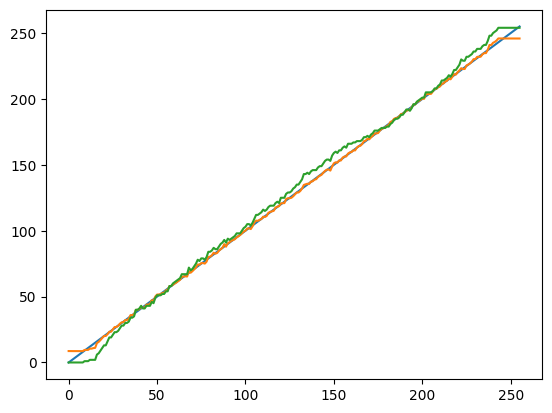

In [33]:
model.train()
train_output = model(inputs).detach()
model.eval()
test_output = model(inputs).detach()
# print(train_output)
# print(test_output)

plt.plot(outputs.cpu())
plt.plot(train_output.cpu())
plt.plot(test_output.cpu())